My goal is to create a chess engine based on convolutional neural nets and reinforcement learning.  But first I will try to answer the question "can convnets learn useful features to represent chess positions".  In this notebook, I will train autoencoders on chess positions and attempt to find neurons that have learned semantically meaningful features.

In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import chess
import chess.pgn
import math

import numpy as np
import tensorflow as tf

from utils import *

# Load data

In [17]:
X = load_boards_from_pgnf('data/ficsgamesdb_201701_standard_nomovetimes_1482388.pgn', num_games=50)
eval_inds = np.random.choice(X.shape[0], 1000)

X_train = X[~eval_inds]
X_eval = X[eval_inds]

## First experiment: fully connected autoencoder

In [18]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [19]:
flat_input_ph = tf.placeholder("float", [None, 8 * 8 * 6])
fc_autoencoder1 = create_fully_connected(flat_input_ph, [60, 30, 20], sess)

In [20]:
# writer = tf.summary.FileWriter('./logs/', graph=tf.get_default_graph())

In [21]:
train(fc_autoencoder1, X_train, True, flat_input_ph, sess, num_iters=2000)

0  cost 0.249028
1000  cost 0.140548


In [22]:
decodedLong = sess.run(fc_autoencoder1['decoded'], feed_dict={flat_input_ph: np.reshape(X_eval, (X_eval.shape[0], -1))})

decoded = np.reshape(decodedLong, (X_eval.shape[0], 8, 8, 6))

In [23]:
np.sum(quantize_arr_vec(decoded) != X_eval) / decoded.size

0.018236979166666667

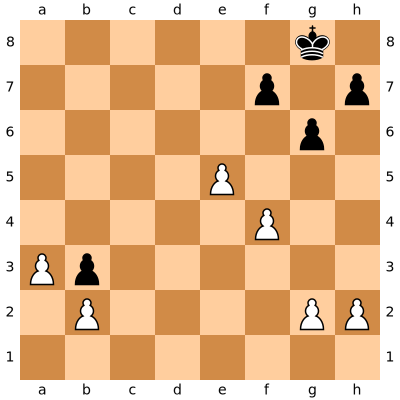

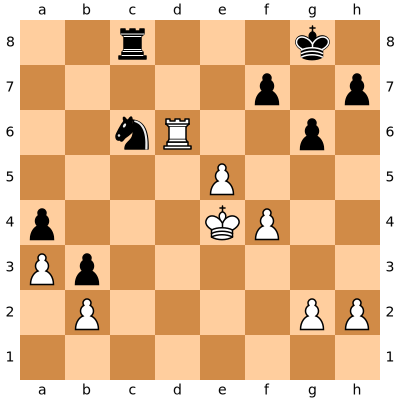

In [24]:
arr_to_board(decoded[40])
arr_to_board(X_eval[40])

## Now a simple conv net

In [27]:
input_ph = tf.placeholder("float", [None, 8, 8, 6])
conv_ae = create_cae(input_ph, [20, 10])

In [30]:
train(conv_ae, X_train, False, input_ph, sess, num_iters=5000)

0  cost 0.243692
1000  cost 0.247397
2000  cost 0.244534
3000  cost 0.242565
4000  cost 0.245605


In [31]:
decoded = sess.run(conv_ae['decoded'], feed_dict={input_ph: X_eval})

(1000, 8, 8, 6)

In [32]:
np.sum(quantize_arr_vec(decoded) != X_eval) / decoded.size

0.062078124999999998

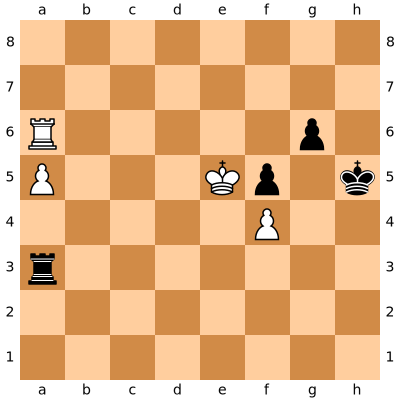

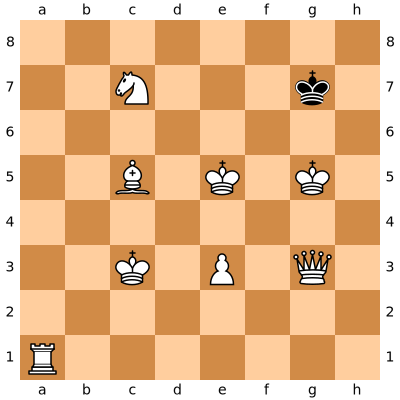

In [34]:
arr_to_board(X_eval[45])
arr_to_board(decoded[45])

# Come back to this later

In [ ]:
neuron = autoencoder['encoded'][0][5]
neuron_grad = tf.gradients(neuron, x)

# board = np.zeros((8,8,6))
board = np.random.normal(size=(8,8,6), scale=.1)
print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

for i in range(10000):
    grad = sess.run(neuron_grad, feed_dict={x: np.reshape(board, (1, -1))})[0]
    grad = np.reshape(grad, (8,8,6))
    board += 1e-3 * grad
    board[board > 1] = 1
    board[board < -1] = -1
    
    if i % 1000 == 0:
        print(sess.run(neuron, feed_dict={x: np.reshape(board, (1, -1))}))

In [ ]:
arr_to_board(board)

In [ ]:
board